<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/prophet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install the Necessary Library

In [ ]:
# Installing the required library
!pip install prophet

In [60]:
# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# For Facebook Prophet (time series forecasting)
from prophet import Prophet
from prophet.plot import plot_plotly

# Evaluation
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 2: Load and Prepare the Dataset

In [81]:
# Load preprocessed data
df = pd.read_csv('/content/bitcoin_analysis.csv')

# Display the first few rows of the data
df.head()

,Date,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3803 entries, 0 to 3802
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3803 non-null   object 
 1   Close   3803 non-null   float64
 2   High    3803 non-null   float64
 3   Low     3803 non-null   float64
 4   Open    3803 non-null   float64
 5   Volume  3803 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 178.4+ KB


### Preprocess the Data

Prophet expects a dataframe with two columns:

- ds: The date column (datetime format).
- y: The target variable (values to forecast).

In [83]:
# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Prepare dataframe for Prophet
df = df.reset_index()[['Date', 'Close']]
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [84]:
df

,ds,y
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3798,2025-02-09,96500.093750
3799,2025-02-10,97437.554688
3800,2025-02-11,95747.429688
3801,2025-02-12,97885.859375


### Train Prophet Model

In [85]:
model = Prophet()  # Initialize model
model.fit(df)  # Train on full data

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/la04wszk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/lar9nz42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74284', 'data', 'file=/tmp/tmpe_5_03oe/la04wszk.json', 'init=/tmp/tmpe_5_03oe/lar9nz42.json', 'output', 'file=/tmp/tmpe_5_03oe/prophet_modelz8_1qlh2/prophet_model-20250213094150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:41:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:41:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Make Future Predictions

In [86]:
future = model.make_future_dataframe(periods=365)  # Predict next 1 year
forecast = model.predict(future)

In [93]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4163,2026-02-09,127967.554554,115582.219389,141646.441053
4164,2026-02-10,128094.606718,115233.365065,142322.572714
4165,2026-02-11,128347.998866,114965.581032,141873.781193
4166,2026-02-12,128458.299280,115594.983011,142138.603512
4167,2026-02-13,128665.183381,115760.413966,142135.390075


### Visualize Predictions

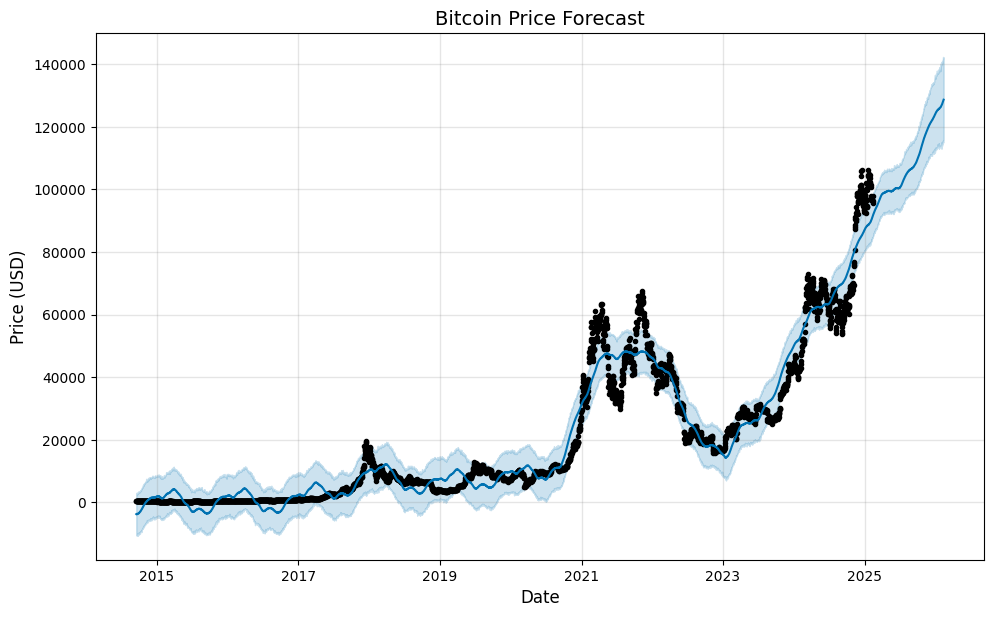

In [89]:
fig = model.plot(forecast)
ax = fig.gca()  # Get current axis

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Price (USD)", fontsize=12)
ax.set_title("Bitcoin Price Forecast", fontsize=14)

plt.show()

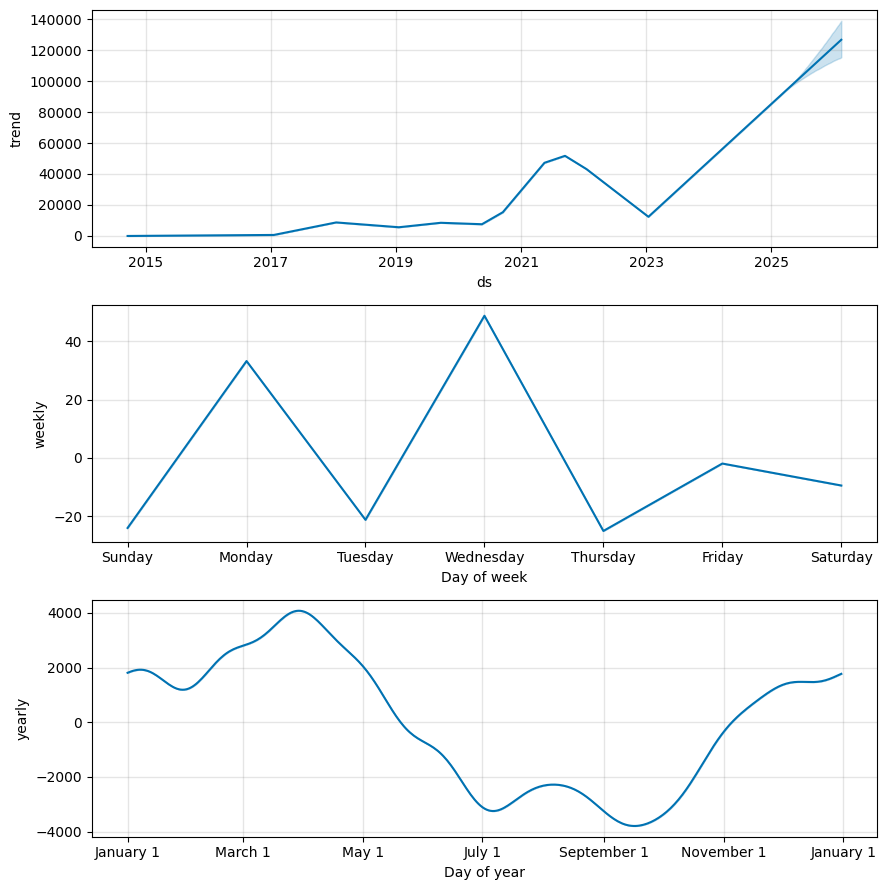

In [95]:
fig2 = model.plot_components(forecast)

In [97]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

## Model Evaluation

### Cross-Validation

In [99]:
# 'initial' specifies the minimum training period, and 'horizon' is how far ahead you forecast.
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='90 days')

INFO:prophet:Making 17 forecasts with cutoffs between 2016-12-27 00:00:00 and 2024-11-15 00:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/slm7tvtv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/o7bcxjzc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51861', 'data', 'file=/tmp/tmpe_5_03oe/slm7tvtv.json', 'init=/tmp/tmpe_5_03oe/o7bcxjzc.json', 'output', 'file=/tmp/tmpe_5_03oe/prophet_modelr5gi56jp/prophet_model-20250213095910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:59:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:59:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/j4ip_97f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/iwjwr3p0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [102]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-12-28,826.965240,796.337145,856.711440,975.921021,2016-12-27
1,2016-12-29,826.623279,795.033831,855.678986,973.497009,2016-12-27
2,2016-12-30,826.621097,794.967204,857.745420,961.237976,2016-12-27
3,2016-12-31,825.092755,793.594923,856.521133,963.742981,2016-12-27
4,2017-01-01,822.784789,790.976394,854.199195,998.325012,2016-12-27


### Performance Metrics

In [104]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,1.267117e+08,11256.630064,8331.789495,0.335152,0.291817,0.339262,0.130719
1,10 days,1.292505e+08,11368.838950,8441.532959,0.338600,0.287103,0.343772,0.124183
2,11 days,1.319424e+08,11486.618340,8555.300989,0.341178,0.284455,0.348569,0.137255
3,12 days,1.359257e+08,11658.719251,8686.713184,0.345226,0.284455,0.354159,0.137255
4,13 days,1.406236e+08,11858.482815,8829.185849,0.348473,0.280138,0.359106,0.143791


In [105]:
# Calculate overall (average) performance metrics
overall_performance = df_p[['mae', 'rmse', 'mape']].mean()
print("Overall Performance Metrics:")
print(overall_performance)

Overall Performance Metrics:
mae     11342.160953
rmse    15621.586305
mape        0.429682
dtype: float64


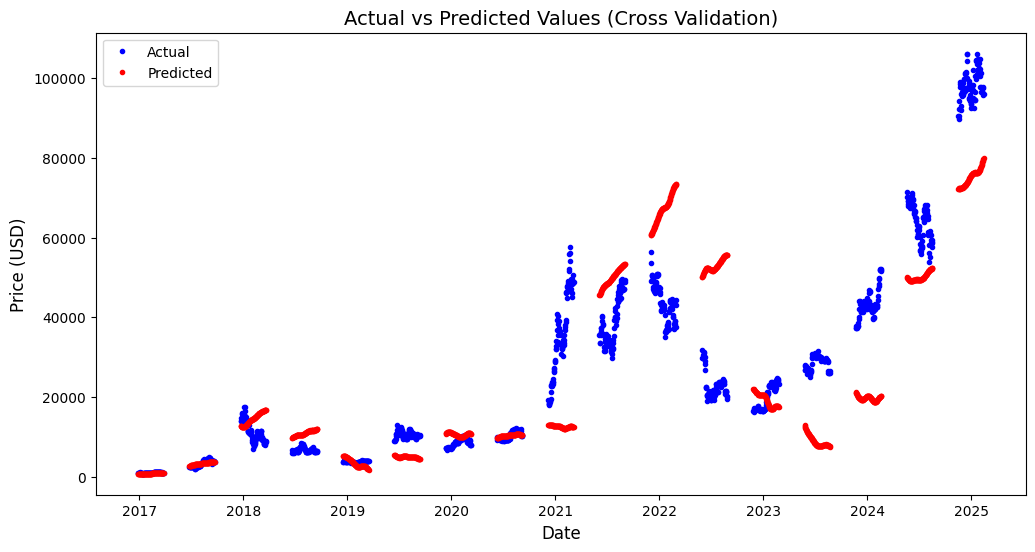

In [106]:
plt.figure(figsize=(12,6))
plt.plot(df_cv['ds'], df_cv['y'], 'b.', label='Actual')      # Actual observations in blue
plt.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Predicted')  # Predicted values in red
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.title("Actual vs Predicted Values (Cross Validation)", fontsize=14)
plt.legend()
plt.show()